# RENT applied to a binary classification problem

An example dataset for demonstration is generated with scikit-learn make_classification. The dataset is split into a train (data, labels) and a test (test_data, test_labels) dataset with corresponding labels. This notebook is for RENT in classification problems. The example for regression will follow. 

In [2]:
# Imports
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Make example data for binary classification
data = make_classification(n_samples=250, n_features=100, n_informative=20, n_redundant=10, random_state=0, shuffle=False)

# Insert data into a pandas dataframe
my_data = pd.DataFrame(data[0])
my_target = data[1]
my_feat_names = ['f{0}'.format(x+1) for x in range(len(my_data.columns))]

# Split data into training and test data using scikit-learn
data, test_data, labels, test_labels = train_test_split(my_data, my_target, test_size=0.3, random_state=0)

Let's have quick look at the training data.

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
106,-2.781523,1.668790,-1.092144,-1.654628,2.431091,-0.934767,1.236988,2.707152,-1.353128,0.256712,...,-1.011332,-0.047554,-1.986357,-0.089812,0.872148,0.668392,1.509412,-0.567483,-0.272206,1.154505
243,-0.319027,-1.582700,-2.530228,3.790455,-1.443424,6.198178,-3.841906,1.752765,-3.137109,2.196795,...,-1.251673,-1.543028,1.669943,-0.211913,-0.381762,0.393836,2.391554,-1.078529,1.383302,-0.571235
4,2.561952,6.538859,-2.159691,-2.692623,-3.958765,-4.349420,1.881853,2.022534,-1.494595,0.409014,...,-0.027384,0.764850,-0.831727,-1.410857,-1.798279,-0.698159,0.606902,0.850187,-0.850901,0.438367
219,-0.629430,-3.191968,-0.681880,6.868408,1.582777,3.321997,-3.044179,-0.122689,1.127910,4.523192,...,-0.521608,0.622348,-0.483599,0.032395,0.133245,-0.611717,1.282187,0.682978,1.795284,1.473537
61,5.271039,-0.122686,0.150363,-0.411842,-1.917968,-3.851898,2.398042,-0.106560,3.216194,1.897365,...,2.125387,-0.050687,0.401114,0.788210,-0.616034,-1.264740,-0.236318,-1.572748,-0.053176,-0.514468


Before we apply RENT to our training data, we may want to identify the the best performing parameter combination `C` and `l1_ratio` for the elastic net models. This step is NOT REQUIRED for running RENT, but it will reduce RENT computation time significantly, since computations will be done for only this best performing combination instead of a range of values for `C` and `l1_ratio`. However, given enough compuational power, ranges of values for `C` and `l1_ratio` can be defined directly in the RENT function. If you play around with RENT and use it the first time, just ignore the next cell.

It is important to remember that the paramter `C` is responsible for the regularization strength in scikit-learn and that it is the inverse regularisation strength parameter lambda as typically defined in textbooks. This can be important to know when you want to further interpret results etc. Furthermore, parameter `l1_ratio` defines the Elastic Net mixing parameter. 

In [4]:
import parameter_selection as ps
import warnings

# Activate this to not show all the convergence warnings.
warnings.filterwarnings("ignore")

# Define ranges for C and l1_ratios
my_reg_params = [0.1, 1, 10] # C
my_l1_params = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1] # l1_ratio
testsize_range = (0.25, 0.25) # Define upper and lower random size of test sets. Use same value to keep test size constant.

best_C, best_l1_ratio = ps.parameter_selection(data=data, 
                                               labels=labels, 
                                               my_reg_params=my_reg_params, 
                                               my_l1_params=my_l1_params,
                                               n_splits=5, 
                                               testsize_range = testsize_range)

In [6]:
print("suggested C: ", best_C)
print("suggested l1_ratio: ", best_l1_ratio)

suggested C:  0.1
suggested l1_ratio:  0.5


**suggested C** and **suggested l1** would be the suggested parameter combination to select for this dataset (based on the procedure above). As stated before, this is not necessary but you can select own parameters you would like to try RENT with, directly in the RENT function. RENT delivers then the best paramter combination found. The process above is useful for speeding up the whole procedure because then, RENT is run only with one parameter combination. For the fundamental application of RENT see the next cell.

RENT offers different settings which are described in the RENT_parallel file. The setting here is the standard setting used in our paper with fewer **tt_splits** (faster computation).

In [8]:
# Import RENT for compuation accross multiple cores
import RENT_parallel as fs

# C parameters you would like to try
my_C_params = [0.1, 1, 10]

# l1-ratios you would like to try
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Apply RENT to your training data
analysis = fs.RENT(data=data, 
                   target=labels,
                   feat_names=data.columns,
                   C=my_C_params,
                   poly='OFF', 
                   scoring='f1',
                   clf='logreg',
                   testsize_range=(0.25, 0.25),
                   num_tt=50, 
                   l1_ratios = my_l1_ratios,
                   verbose = 0)

Dim data: (175, 100)
Dim target (175,)
regularization parameters C: [0.1, 1, 10]
l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
num TT splits: 50
data type: <class 'pandas.core.frame.DataFrame'>
verbose: 0


Now it is time to determine the stability of selection of each feature in the training data. The command below will extract useful information from the distribution of weights (based on `num_tt`, the number of train-test-splits or number of models in the ensemble) seperately for each feature.

In [9]:
# Analyse distribution of feature weights across `num_tt` models. 
analysis.run_analysis()

We can take a closer look into different calculations from RENT. The scores dataframe shows the average prediction scores with the defined scoring measure (set in RENT) for a given combination of l1_ratios (rows) and C parameters (columns), over the different models in RENT (`num_tt` represents the number of models). The structure for zeroes is the same - here we show the percentage of variables set to 0 for a parameter combination over the models in RENT. 
**scores** and **zeroes** are both important as we want to reach a high score but also reduce the feature set size simultaneously.

In [10]:
scores = analysis.get_scores_summary_by_regParam()
pd.DataFrame(scores)

,0.1,1.0,10.0
0.00,0.731301,0.721950,0.710399
0.10,0.743257,0.728037,0.712983
0.25,0.761181,0.729751,0.715464
0.50,0.779276,0.732081,0.723725
0.75,0.791459,0.742322,0.725538
0.90,0.797868,0.748056,0.731890
1.00,0.801245,0.753481,0.736725


In [11]:
zeroes = analysis.get_average_zero_features()
pd.DataFrame(zeroes)

,0.1,1.0,10.0
0.00,0,0,0
0.10,0.2328,0.0712,0.018
0.25,0.4876,0.176,0.0582
0.50,0.736,0.3232,0.1406
0.75,0.8718,0.4334,0.2458
0.90,0.9168,0.4884,0.3154
1.00,0.9334,0.5188,0.3592


To find the best combination, we norm **scores** and **zeroes** to bring them on a comparable scale. Then, with the harmonic mean of the two matrices, we build a new matrix called **combi** where we now take the parameter combination with the highest value.

In [12]:
import numpy as np

normed_scores = (scores-np.nanmin(scores.values))/(np.nanmax(scores.values)-np.nanmin(scores.values))
normed_zeroes = (zeroes-np.nanmin(zeroes.values))/(np.nanmax(zeroes.values)-np.nanmin(zeroes.values))
normed_zeroes = normed_zeroes.astype("float")

combi = (normed_scores ** -1 + normed_zeroes ** -1) ** -1
pd.DataFrame(combi)

,0.1,1.0,10.0
0.00,0.000000,0.000000,0.000000
0.10,0.147617,0.054764,0.011493
0.25,0.270035,0.100023,0.029435
0.50,0.386523,0.141283,0.074316
0.75,0.456332,0.200021,0.102061
0.90,0.486211,0.231289,0.139148
1.00,0.500000,0.255895,0.165308


From the combination matrix we see that the combination C = 0.1, l1_ratio = 1.0 has the highest value. We will use it now as the **best** parameter combination and come to the actual feature selection step where we select features based on three quality criteria **tau_1**, **tau_2** and **tau_3** (more info in the paper). With the function **get_spec_weights_summary** we get a summary dataframe which shows us the values for the quality criteria for each feature, the actual reduced dataset with **only** important features remaining and an array of the positions of the selected features in the columns of the original dataframe.

The plot below shows the absolute count for each feature, i.e. how often it is assigned a value not equal to 0.

C:  0.1 l1_ratio:  1.0


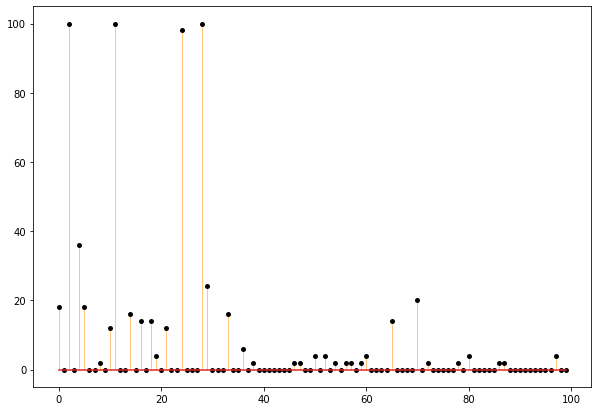

In [13]:
best_combi_row, best_combi_col  = np.where(combi == np.nanmax(combi.values))
l1_ratio = combi.index[np.nanmax(best_combi_row)]
C = combi.columns[np.nanmin(best_combi_col)]
print("C: ", C, "l1_ratio: ", l1_ratio)

summary_spec_weights, sel_feat_df, features = analysis.get_spec_weights_summary(C=C, l1_ratio=l1_ratio, tau_1=0.9, tau_2=0.9, tau_3=0.975)

In [14]:
# summary specific weight shows the summary statistics for each feature
summary_spec_weights

"C=0.1, l1=1.0",0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
perc non-zero,0.180000,0.0,1.0,0.0,0.360000,0.180000,0.0,0.0,0.020000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0
sig_criterium,0.180000,0.0,1.0,0.0,0.360000,0.180000,0.0,0.0,0.020000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0
t_test,0.995101,NaN,1.0,NaN,0.999877,0.995445,NaN,NaN,0.841308,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921838,NaN,NaN


In [15]:
# sel_feat_df contains the selected features
sel_feat_df

,2,11,24,28
106,-1.092144,0.767444,-5.367330,4.706127
243,-2.530228,-1.337445,-12.114991,1.498368
4,-2.159691,-0.754486,1.960419,-12.299008
219,-0.681880,-4.744974,-8.493850,4.496618
61,0.150363,-3.254751,-1.939989,-5.877661
...,...,...,...,...
67,1.085821,2.250785,-2.744806,4.055058
192,-7.868931,-0.575661,4.534583,4.101179
117,-0.206240,0.336026,-5.762508,9.460614
47,3.412366,-3.460888,9.867353,10.017678


In [16]:
features

array([ 2, 11, 24, 28], dtype=int64)

Now we want to evaluate the predictive power of the selected features. Therefore, we reduce the train and test datasets to the selected features and build a machine learning model. Here, we use a Logistic Regression model without any penalty but you are free to use other learning algorithms, as well. Test scores are evaluated with different measures (**f1**, **accuarcy**, **matthews correlation coefficient**) 

In [17]:
# predict test set

# Import what is needed for prediction and evaluation of predictions from test set
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

# Scale the data accordingly
sc = StandardScaler()
train_data_1 = sc.fit_transform(data.loc[:, sel_feat_df.columns])
test_data_1 = sc.transform(test_data.loc[:, sel_feat_df.columns])

# Train model with 
model = LR(penalty='none', max_iter=8000, solver="saga", random_state=0).\
        fit(train_data_1, labels)

# Print results
print("All features f1 1: ", f1_score(test_labels, model.predict(test_data_1)))
print("All features f1 0: ", f1_score(1 - test_labels, 1 - model.predict(test_data_1)))
print("All features acc: ", accuracy_score(test_labels, model.predict(test_data_1)))
print("All features matthews: ", matthews_corrcoef(test_labels, model.predict(test_data_1)))

All features f1 1:  0.708860759493671
All features f1 0:  0.676056338028169
All features acc:  0.6933333333333334
All features matthews:  0.38516444325982163


With a feasibility study we can evaluate how useful feature selection is at all on the dataset (permutation of the test labels), and if the RENT features are relevant or if it is not relevant which features are used to train a model (random feature drawing).

In [18]:
analysis.feasibility_study(test_data=test_data, test_labels=test_labels, feature_size= len(sel_feat_df.columns), 
                          features=sel_feat_df.columns)

Average score random feature drawing:  0.05834488694202273
Average score permutation of test labels:  -0.0069543580033023375


Besides the feature selection RENT has the property of summarizing the predictive behavior of single samples. Before we can generate histogram plots for them we need to check how often they were classified incorrectly. For each patient the following table shows how often a the patient has been part of a test set within RENT, which class his true class is, how often he has not been predicted correctly and the corresponding percentage of incorrect prediction.

In [19]:
inc = analysis.get_spec_incorr_lables(C=0.1, l1_ratio=1)

In [20]:
inc[0]

,nr.test,class,nr.incorrect,perc incorrect
106,17,1,0,0.0
243,10,1,0,0.0
4,11,0,0,0.0
219,7,1,0,0.0
61,13,0,0,0.0
...,...,...,...,...
67,7,1,0,0.0
192,13,1,0,0.0
117,17,1,0,0.0
47,14,0,0,0.0


The next plot is based on a PCA plot on the incorrect predictions and shows a mapping of the patients about the level of incorrectness. Patiens who were incorrect in less than **25%** are the true positive/negative and those above **75%** incorrectness were the false positive/negative. The patients between are the neutral ones, correspondingly.

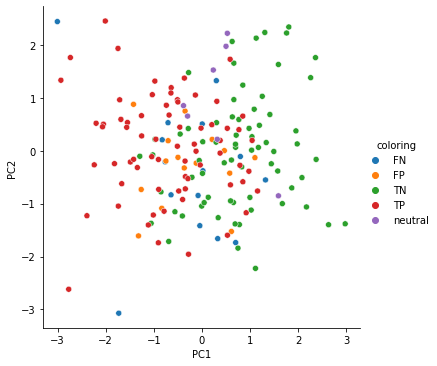

In [21]:
analysis.confusion_variance_plot()

With histogram plots we can demonstrate the predictions for single patients in a logistic regression model over the different RENT models.

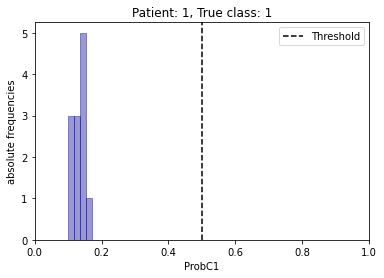

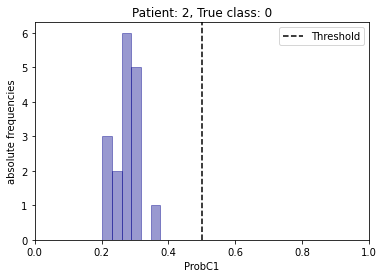

In [22]:
analysis.pred_proba()
analysis.pred_proba_plot(C=0.1, l1_ratio=1, patient_id=[1,2])